# import the libraries

In [ ]:
# https://github.com/chembl/notebooks/blob/main/ChEMBL_webresource_client_examples.ipynb
from chembl_webresource_client.new_client import new_client
from IPython.display import SVG
import requests
import pandas as pd
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem, PandasTools, rdRGroupDecomposition, Descriptors, Draw, Descriptors3D
from rdkit import DataStructs, rdBase, Chem

import platform
print('python version: ' + platform.python_version())
print(f'rdkit version: {rdBase.rdkitVersion}')

python version: 3.12.6
rdkit version: 2024.03.6


# APIで化合物情報を取得

### UniProt IDからTarget ChEMBL IDを検索

In [3]:
uniprot_id = input('UniProt ID?') # P29597
target = new_client.target.get(
    target_components__accession=uniprot_id
    ).only(
        'target_chembl_id', 
        'organism', 
        'pref_name', 
        'target_type'
        )
pd.DataFrame.from_records(target)

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Tyrosine-protein kinase TYK2,CHEMBL3553,SINGLE PROTEIN
1,Homo sapiens,Tyrosine-protein kinase TYK2,CHEMBL3553,SINGLE PROTEIN
2,Homo sapiens,Janus Kinase (JAK),CHEMBL2363062,PROTEIN FAMILY
3,Homo sapiens,JAK1/JAK2/TYK2,CHEMBL3301390,PROTEIN COMPLEX
4,Homo sapiens,JAK1/TYK2,CHEMBL3301391,PROTEIN COMPLEX
5,Homo sapiens,JAK2/TYK2,CHEMBL3301392,PROTEIN COMPLEX


### ChEMBL IDからデータを取得する

In [ ]:
ChEMBL_id = input("Enter the ChEMBL ID: ") # CHEMBL3553
activities = new_client.activity.filter(
    target_chembl_id__in=ChEMBL_id,  ##Specify a list of example targets
    pchembl_value__gte=5,  ##Specify a minimum threshold of the pChEMBL activity value. Note that pCHEMBL = -log10(IC50, XC50, AC50, Ki, Kd, potency). Greater than or equal to 5 (10um) is a typical minimum rule of thumb for binding activity between a compound and a protein target. 
    assay_type='B',  ##Only look for Binding Assays
).only([
    'molecule_chembl_id',
    'molecule_pref_name',
    'target_chembl_id',
    'target_pref_name',
    'parent_molecule_chembl_id',
    'pchembl_value',
    'canonical_smiles',
    'assay_description',
    'document_chembl_id',
    'document_journal',
    'document_year',
])
df = pd.DataFrame.from_records(activities)

# Mol File 追加
PandasTools.AddMoleculeColumnToFrame(df, 'canonical_smiles', 'Molecule', includeFingerprints=True)
# Murcko Scaffoldの追加
PandasTools.AddMurckoToFrame(df, molCol='Molecule', MurckoCol='Murcko_SMILES')
PandasTools.AddMurckoToFrame(df, molCol='Molecule', MurckoCol='Murcko_generic_SMILES', Generic=True)
PandasTools.AddMoleculeColumnToFrame(df, molCol='Murcko_Mol', smilesCol='Murcko_SMILES')
PandasTools.AddMoleculeColumnToFrame(df, molCol='Murcko_generic_Mol', smilesCol='Murcko_generic_SMILES')
# PandasTools.FrameToGridImage(df[:8], column='Murcko_generic_Mol', legendsCol=None, molsPerRow=4)

# 文献数
print("the number of Document ChEMBL ID is " + str(len(df['document_chembl_id'].unique())))

# 骨格数情報 SMILESじゃないとなぜか反映されない
print("the number of Murcko generic scaffold is " + str(len(df['Murcko_generic_SMILES'].unique())))
print("the number of Murcko scaffold is " + str(len(df['Murcko_SMILES'].unique())))

# descriptorの追加
df['MW'] = df['canonical_smiles'].apply(lambda x : Descriptors.MolWt(Chem.MolFromSmiles(x)))
df['Mol LogP'] = df['canonical_smiles'].apply(lambda x : Descriptors.MolLogP(Chem.MolFromSmiles(x)))
df['TPSA'] = df['canonical_smiles'].apply(lambda x : Descriptors.TPSA(Chem.MolFromSmiles(x)))
df['Ct HA'] = df['canonical_smiles'].apply(lambda x : Descriptors.HeavyAtomCount(Chem.MolFromSmiles(x)))
df['Ct F'] = df['canonical_smiles'].apply(lambda x : x.count('F'))
df['HBD'] = df['canonical_smiles'].apply(lambda x : Descriptors.NumHDonors(Chem.MolFromSmiles(x)))
df['HBA'] = df['canonical_smiles'].apply(lambda x : Descriptors.NumHAcceptors(Chem.MolFromSmiles(x)))
df['Ct RB'] = df['canonical_smiles'].apply(lambda x : Descriptors.NumRotatableBonds(Chem.MolFromSmiles(x)))
df['Ct Ar'] = df['canonical_smiles'].apply(lambda x : Descriptors.NumAromaticRings(Chem.MolFromSmiles(x)))


# molecule = new_client.molecule
# mols = molecule.filter(pref_name__iexact='aspirin')
# df = pd.DataFrame(mols)
# df

#### 先頭3化合物を表示

In [19]:
df[df['molecule_pref_name'].notna()].filter(items=[
    'molecule_pref_name',
    'Molecule', 
    'pchembl_value'
]
).head(3)

,molecule_pref_name,Molecule,pchembl_value
6,TAE-684,<rdkit.Chem.rdchem.Mol object at 0x171e4f3e0>,5.64
7,AT-9283,<rdkit.Chem.rdchem.Mol object at 0x171e4f4c0>,9.00
9,HESPERADIN,<rdkit.Chem.rdchem.Mol object at 0x171e4f6f0>,7.12


#### 先頭3化合物の構造式を表示

In [22]:
list(df['molecule_pref_name'][:3])

[None, None, None]

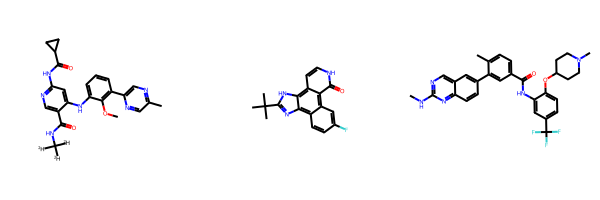

In [ ]:
Draw.MolsToGridImage(
    df['Molecule'][:3], 
    molsPerRow=3, 
    subImgSize=(200, 200), 
    # legends=list(df['molecule_pref_name'][:3]) # Noneは表示されない
    )

### 統計df

In [3]:
dfd = df.groupby(['document_year'])['document_chembl_id'].describe()
dfm = df.groupby(['document_year'])['Murcko_generic_SMILES'].describe()
dfg = df.groupby(['document_chembl_id'])['Murcko_generic_SMILES'].describe()

##### Count Documents and Scaffolds by Year

In [4]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(x=dfd.index, y=dfd['unique'], name='Document count'))
fig.add_trace(go.Bar(x=dfm.index, y=dfm['unique'], name='Scaffold count'))

fig.update_layout(
    title='Murcko generic scaffold v.s. Year',
    # showlegend=False, # Legendのon/off
    width=1000,
    # height=700
    barmode='group',
)
fig.show()

# 構造の三次元情報を計算

In [65]:
df['AddHs'] = df['Molecule'].apply(lambda x : AllChem.AddHs(x))
# Embed molecules with error handling and detailed logging
def embed_molecule(mol, idx):
    try:
        AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
        return mol
    except RuntimeError as e:
        print(f"Embedding failed for molecule at index {idx}: {e}")
        return None

df['3D'] = df['AddHs'].apply(lambda x, idx: embed_molecule(x, idx), args=(df.index,))

# Check if embedding was successful
def calculate_npr1(mol, idx):
    if mol and mol.GetNumConformers() > 0:
        try:
            return Descriptors3D.NPR1(mol)
        except Exception as e:
            print(f"Failed to calculate NPR1 for molecule at index {idx}: {e}")
            return None
    else:
        return None

def calculate_npr2(mol, idx):
    if mol and mol.GetNumConformers() > 0:
        try:
            return Descriptors3D.NPR2(mol)
        except Exception as e:
            print(f"Failed to calculate NPR2 for molecule at index {idx}: {e}")
            return None
    else:
        return None
# Calculate NPR1 and NPR2 with detailed logging
df['NPR1'] = df['3D'].apply(lambda x, idx: calculate_npr1(x, idx), args=(df.index,))
df['NPR2'] = df['3D'].apply(lambda x, idx: calculate_npr2(x, idx), args=(df.index,))

# Remove hydrogens
df['AddHs'] = df['3D'].apply(lambda x: AllChem.RemoveHs(x) if x else None)

[22:46:20] UFFTYPER: Unrecognized charge state for atom: 1


### 2D plot

In [64]:
import plotly.express as px
fig = px.scatter(df,
    x='NPR1',
    y='NPR2',
    # color='Molecule Max Phase',
    # color='AlogP',
    # color='Document ChEMBL ID',
    # color='Murcko_generic_SMILES',
    # size='pChEMBL Value',
    # hover_name='Molecule ChEMBL ID',
    # hover_data=['Document ChEMBL ID', df.index],
    opacity=0.5
)
fig.update_layout(
    title='LLE v.s. MW',
    # showlegend=False, # Legendのon/off
    width=600,
    # height=700,
    xaxis=dict(range= (0,1))
) 
fig.update_xaxes
fig.show()


### 3D plot

In [34]:
import plotly.express as px
fig = px.scatter_3d(df,
                    x='PMI1',
                    z='PMI2',
                    y='PMI3',
                    # color='Document ChEMBL ID',
                    # color='Murcko_generic_SMILES',
                    # size='pChEMBL Value',
                    # hover_name='Molecule ChEMBL ID',
                    # hover_data=['Molecule ChEMBL ID',df.index],
                    opacity=0.5
                    )
fig.update_layout(
    # showlegend=False, # Legendのon/off
    width=500,
    height=500,
    xaxis=dict(range= (0,1))
    ) 
fig.show()

# save sdf

In [80]:
import datetime

# Get today's date
today = datetime.date.today().strftime('%Y-%m-%d')

PandasTools.WriteSDF(df, f'{ChEMBL_id}_{today}.sdf', molColName='Molecule', properties=list(df.columns))

,assay_description,canonical_smiles,document_chembl_id,document_journal,document_year,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,target_chembl_id,...,HBD,HBA,Ct RB,Ct Ar,AddHs,3D,NPR1,NPR2,ID,Molecule
0,Inhibition of TYK2 in human whole blood assess...,[2H]C([2H])([2H])NC(=O)c1cnc(NC(=O)C2CC2)cc1Nc...,CHEMBL4765480,J Med Chem,2021,CHEMBL4780233,None,CHEMBL4803313,6.63,CHEMBL3553,...,3,7,8,3,<rdkit.Chem.rdchem.Mol object at 0x316722f10>,<rdkit.Chem.rdchem.Mol object at 0x32cb72340>,0.270971,0.916959,,
1,Inhibition of Tyrosine kinase 2 kinase,CC(C)(C)c1nc2c3ccc(F)cc3c3c(=O)[nH]ccc3c2[nH]1,CHEMBL1135866,Bioorg Med Chem Lett,2002,CHEMBL21156,None,CHEMBL21156,9.00,CHEMBL3553,...,2,2,0,4,<rdkit.Chem.rdchem.Mol object at 0x316722d50>,<rdkit.Chem.rdchem.Mol object at 0x32075bd10>,0.314992,0.713833,,
2,Inhibition of Tyk2 by HTRF kinase assay,CNc1ncc2cc(-c3cc(C(=O)Nc4cc(C(F)(F)F)ccc4OC4CC...,CHEMBL1149344,J Med Chem,2006,CHEMBL386661,None,CHEMBL386661,5.56,CHEMBL3553,...,2,6,6,4,<rdkit.Chem.rdchem.Mol object at 0x316722dc0>,<rdkit.Chem.rdchem.Mol object at 0x321134040>,0.2226,0.905104,,
3,Inhibition of Tyk2 by HTRF kinase assay,Cc1ccc(C(=O)Nc2cccc(C(F)(F)F)c2)cc1-c1ccc2nc(N...,CHEMBL1149344,J Med Chem,2006,CHEMBL215943,None,CHEMBL215943,5.74,CHEMBL3553,...,2,6,7,4,<rdkit.Chem.rdchem.Mol object at 0x316722ce0>,<rdkit.Chem.rdchem.Mol object at 0x3211340b0>,0.089886,0.927875,,
4,Inhibition of Tyk2 by HTRF assay,Cc1cccc(C)c1-n1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)c...,CHEMBL1143254,J Med Chem,2008,CHEMBL410295,None,CHEMBL410295,5.92,CHEMBL3553,...,1,9,4,6,<rdkit.Chem.rdchem.Mol object at 0x316722c70>,<rdkit.Chem.rdchem.Mol object at 0x321134120>,0.209885,0.935508,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2343,Selectivity interaction (HTRF activity assay) ...,CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3...,CHEMBL5465560,None,2024,CHEMBL3622821,UPADACITINIB,CHEMBL3622821,7.26,CHEMBL3553,...,2,4,3,3,<rdkit.Chem.rdchem.Mol object at 0x31671c740>,<rdkit.Chem.rdchem.Mol object at 0x32cb71850>,0.237914,0.960485,,
2344,Selectivity interaction (HTRF activity assay) ...,CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3...,CHEMBL5465560,None,2024,CHEMBL3622821,UPADACITINIB,CHEMBL3622821,5.33,CHEMBL3553,...,2,4,3,3,<rdkit.Chem.rdchem.Mol object at 0x31671c6d0>,<rdkit.Chem.rdchem.Mol object at 0x32cb719a0>,0.15651,0.964293,,
2345,Selectivity interaction (Biochemical assay) EU...,CC[C@@H]1CN(C(=O)NCC(F)(F)F)C[C@@H]1c1cnc2cnc3...,CHEMBL5465560,None,2024,CHEMBL3622821,UPADACITINIB,CHEMBL3622821,5.33,CHEMBL3553,...,2,4,3,3,<rdkit.Chem.rdchem.Mol object at 0x31671c660>,<rdkit.Chem.rdchem.Mol object at 0x32cb71a10>,0.213548,0.95813,,
2346,Selectivity interaction (Kinase panel (cellula...,CCN1CCN(c2ccc(Nc3cc(N(C)C(=O)Nc4c(Cl)c(OC)cc(O...,CHEMBL5465560,None,2024,CHEMBL1852688,INFIGRATINIB,CHEMBL1852688,5.48,CHEMBL3553,...,2,8,8,3,<rdkit.Chem.rdchem.Mol object at 0x31671c5f0>,<rdkit.Chem.rdchem.Mol object at 0x32cb70820>,0.082547,0.976734,,

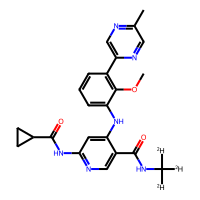
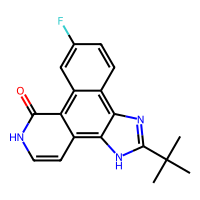
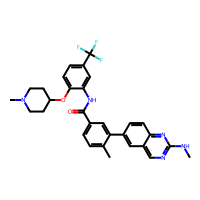
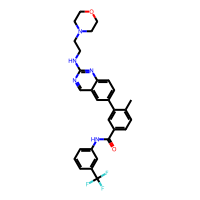
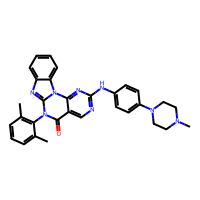
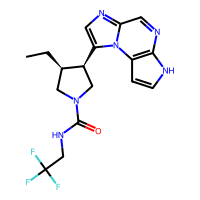
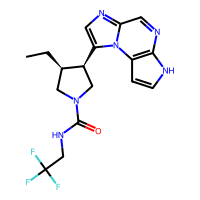
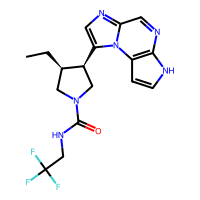
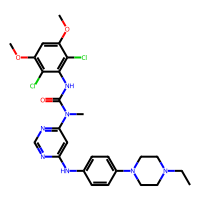
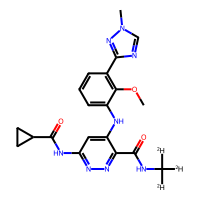

In [81]:
PandasTools.LoadSDF('CHEMBL3553_2025-02-13.sdf', molColName='Molecule', includeFingerprints=True)